<a href="https://colab.research.google.com/github/zackives/upenn-cis-2450/blob/main/Lectures_2_4_Data_Acquisition_Wrangling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview of Part I

As we start our journey into Big Data Analytics, the first thing we need to do is **get the data** in the form we need for analysis!  We'll start with an overview of how to acquire and *wrangle* data.

This notebook gives us a series of examples for:

* Acquiring data from files and remote sources
* Information extraction over HTML content
* A basic "vocabulary" of operators over tables (the relational algebra)

* "Data wrangling" or integration:
  * Cleaning and filtering data, using rules and based operations
  * Linking data across dataframes or relations
  * The need for approximate match and record linking

## The Motivating Question
To illustrate the principles, we focus on the question of how old company CEOs and founders are.  The question was in part motivated by the following New York Times article:

* Founders of Successful Tech Companies Are Mostly Middle-Aged: https://www.nytimes.com/2019/08/29/business/tech-start-up-founders-nest.html?searchResultPosition=2

So let's test this hypothesis!

In [1]:
!pip3 install git+https://github.com/anhaidgroup/py_stringsimjoin.git@rel_0_3_6

  Cloning https://github.com/anhaidgroup/py_stringsimjoin.git (to revision rel_0_3_6) to /tmp/pip-req-build-o9z6qh6n
  Running command git clone --filter=blob:none --quiet https://github.com/anhaidgroup/py_stringsimjoin.git /tmp/pip-req-build-o9z6qh6n
  Running command git checkout -b rel_0_3_6 --track origin/rel_0_3_6
  Switched to a new branch 'rel_0_3_6'
  Branch 'rel_0_3_6' set up to track remote branch 'rel_0_3_6' from 'origin'.
  Resolved https://github.com/anhaidgroup/py_stringsimjoin.git to commit d3ab2b31a8f9515e11bfa7abf9c33722cf6c9938
  Preparing metadata (setup.py) ... done


In [2]:
#!pip3 install git+https://github.com/anhaidgroup/py_stringsimjoin.git@rel_0_3_3

In [3]:
# Let's install some libraries useful for processing web data

# For string similarity
#!pip3 install py_stringsimjoin

# # lxml to parse xml tree
!pip3 install lxml

In [4]:
# Imports we'll use through the notebook, collected here for simplicity

# For parsing dates and being able to compare
import datetime

# For fetching remote data
import urllib
import urllib.request

# Pandas dataframes and operations
import pandas as pd

# Numpy matrix and array operations
import numpy as np

# Sqlite is a simplistic database
import sqlite3

# Approximate string matching, see
import py_stringsimjoin as ssj
import py_stringmatching as sm

# Data visualization
import matplotlib



In [5]:
dir(sm)

['Affine',
 'AlphabeticTokenizer',
 'AlphanumericTokenizer',
 'BagDistance',
 'Cosine',
 'DelimiterTokenizer',
 'Dice',
 'Editex',
 'GeneralizedJaccard',
 'HammingDistance',
 'Jaccard',
 'Jaro',
 'JaroWinkler',
 'Levenshtein',
 'MongeElkan',
 'NeedlemanWunsch',
 'OverlapCoefficient',
 'PartialRatio',
 'QgramTokenizer',
 'SmithWaterman',
 'SoftTfIdf',
 'Soundex',
 'TfIdf',
 'TverskyIndex',
 'WhitespaceTokenizer',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'similarity_measure',
 'tokenizer',
 'utils']

# Lecture Module 1: Acquiring Data

To test our hypothesis, we might want:

1. A list of companies (and, for futher details, perhaps their lines of business)
2. A list of company CEOs
3. Ages of the CEOs

We'll go through each of these using real data from the web.

### Reading Structured Data Sources

Let's start by looking up data about companies.  An example of this is at:

https://gist.githubusercontent.com/jvilledieu/c3afe5bc21da28880a30/raw/a344034b82a11433ba6f149afa47e57567d4a18f/Companies.csv

which has some nicely detailed information about companies, their categories, when they were founded, etc.  Let's load this (remote) CSV file into a dataframe.

In [6]:
data = urllib.request.urlopen(\
       'https://gist.github.com/jvilledieu/c3afe5bc21da28880a30/raw/a344034b82a11433ba6f149afa47e57567d4a18f/Companies.csv')

company_data_df = pd.read_csv(data)


In [7]:
# Let's write it to SQL, and read it back

conn = sqlite3.connect('local.db')

company_data_df.to_sql("companies", conn, if_exists="replace", index=False)

pd.read_sql_query('select * from companies', conn)

,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,1 750 000,acquired,USA,NY,New York City,New York,1,01/06/2012,2012-06,2012-Q2,2012.0,30/06/2012,30/06/2012
1,/organization/tv-communications,&TV Communications,http://enjoyandtv.com,|Games|,Games,4 000 000,operating,USA,CA,Los Angeles,Los Angeles,2,None,None,None,NaN,04/06/2010,23/09/2010
2,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,40 000,operating,EST,None,Tallinn,Tallinn,1,26/10/2012,2012-10,2012-Q4,2012.0,09/08/2012,09/08/2012
3,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|iPhone|Apps|Mobile|iOS|E-Commerce|,Electronics,1 500 000,operating,GBR,None,London,London,1,01/04/2011,2011-04,2011-Q2,2011.0,01/04/2011,01/04/2011
4,/organization/n-plusn,+n (PlusN),http://plusn.com,|Software|,Software,1 200 000,operating,USA,NY,New York City,New York,2,01/01/2012,2012-01,2012-Q1,2012.0,29/08/2012,04/09/2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47753,/organization/zzish,Zzish,http://www.zzish.com,|Analytics|Gamification|Developer APIs|iOS|Android|Education|,Education,320 000,operating,GBR,None,London,London,1,28/01/2013,2013-01,2013-Q1,2013.0,24/03/2014,24/03/2014
47754,/organization/zznode-science-and-technology-co-ltd,ZZNode Science and Technology,http://www.zznode.com,|Enterprise Software|,Enterprise Software,1 587 301,operating,CHN,None,Beijing,Beijing,1,None,None,None,NaN,01/04/2012,01/04/2012
47755,/organization/zzzzapp-com,Zzzzapp Wireless ltd.,http://www.zzzzapp.com,|Web Development|Advertising|Wireless|Mobile|,Web Development,97 398,operating,HRV,None,Split,Split,5,13/05/2012,2012-05,2012-Q2,2012.0,01/11/2011,10/09/2014
47756,/organization/a-list-games,[a]list games,http://www.alistgames.com,|Games|,Games,9 300 000,operating,None,None,None,None,1,None,None,None,NaN,21/11/2011,21/11/2011


## Companies' CEOs: a Web Table

Now we need to figure out who the CEOs are for corporations.  One place to look is Wikipedia, which has an HTML table describing the CEOs.

https://en.wikipedia.org/wiki/List_of_chief_executive_officers#List_of_CEOs

Pandas actually makes it easy to read HTML tables...

In [8]:
# Now let's read an HTML table!

company_ceos_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_chief_executive_officers#List_of_CEOs')[1]

company_ceos_df

,Company,Executive,Title,Since,Notes,Updated
0,Accenture,Julie Sweet,CEO[1],2019,"Succeeded Pierre Nanterme, died",2019-01-31
1,Aditya Birla Group,Kumar Mangalam Birla,Chairman[2],1995[2],Part of the Birla family business house in India,2018-10-01
2,Adobe Systems,Shantanu Narayen,"Chairman, president and CEO[3]",2007,Formerly with Apple,2018-10-01
3,Airbus,Guillaume Faury,CEO[4],2012,Succeeded Louis Gallois,2017-11-14
4,Alibaba,Eddie Wu,Director and CEO[5],2023[6],NaN,2024-07-19
...,...,...,...,...,...,...
130,Warner Brothers,Ann Sarnoff,Chairwoman and CEO[122],2019,First woman to hold the position at the company; succeeded Kevin Tsujihara,2019-10-10
131,WarnerMedia,Jason Kilar,CEO[123],2020,Previously with Hulu and Amazon,2020-11-19
132,Wells Fargo,Charles Scharf,CEO and president[124],2019,"Succeeded John Stumpf, previously COO",NaN
133,Whole Foods Market,John Mackey,CEO[125],1980,Co-founder,2017-11-11


## The Problem Gets Harder... Extracting Structured Fields

So far we have companies and CEOs.  But we don't have information on how old the CEOs are!

For a solution, we're going to go back to Wikipedia -- this time looking at the web pages for the CEOs!

This involves "crawling" the CEO pages, and "scraping" the relevant content.  In other words we have to do *information extraction*.

We'll start by constructing a list of CEO web pages, from the Company CEO dataframe above.  For this, we need to take the names and do a bit of tweaking, for example adding underscores instead of spaces.

In [9]:
crawl_list = []

for executive in company_ceos_df['Executive']:
  crawl_list.append('https://en.wikipedia.org/wiki/' + executive.replace(' ', '_'))

crawl_list

['https://en.wikipedia.org/wiki/Julie_Sweet',
 'https://en.wikipedia.org/wiki/Kumar_Mangalam_Birla',
 'https://en.wikipedia.org/wiki/Shantanu_Narayen',
 'https://en.wikipedia.org/wiki/Guillaume_Faury',
 'https://en.wikipedia.org/wiki/Eddie_Wu',
 'https://en.wikipedia.org/wiki/Andy_Jassy',
 'https://en.wikipedia.org/wiki/Lisa_Su',
 'https://en.wikipedia.org/wiki/Stephen_Squeri',
 'https://en.wikipedia.org/wiki/Joseph_R._Swedish',
 'https://en.wikipedia.org/wiki/Tim_Cook',
 'https://en.wikipedia.org/wiki/Lakshmi_Niwas_Mittal',
 'https://en.wikipedia.org/wiki/John_Stankey',
 'https://en.wikipedia.org/wiki/Charles_Woodburn',
 'https://en.wikipedia.org/wiki/Tapan_Singhel',
 'https://en.wikipedia.org/wiki/Carlos_Torres_Vila',
 'https://en.wikipedia.org/wiki/Brian_Moynihan',
 'https://en.wikipedia.org/wiki/C.S._Venkatakrishnan',
 'https://en.wikipedia.org/wiki/Warren_Buffett',
 'https://en.wikipedia.org/wiki/Hubert_Joly',
 'https://en.wikipedia.org/wiki/Sunil_Bharti_Mittal',
 'https://en.wiki

In [10]:
# Use urllib.urlopen to crawl all pages in crawl_list, and store the response of the page
# in list pages

pages = []

for url in crawl_list:
    page = url.split("/")[-1] #extract the person name at the end of the url
    print('Looking at file %s' % page)

    # An issue: some of the accent characters won't work.  We need to convert them
    # into an HTML URL.  We'll split the URL, then use "parse.quote" to change
    # the structure, then re-form the URL
    url_list = list(urllib.parse.urlsplit(url))
    url_list[2] = urllib.parse.quote(url_list[2])
    url_ascii = urllib.parse.urlunsplit(url_list)
    try:
      response = urllib.request.urlopen((url_ascii))
      #Save page and url for later use.
      pages.append(response)
    except urllib.error.URLError as e:
      print(e.reason)


Looking at file Julie_Sweet
Looking at file Kumar_Mangalam_Birla
Looking at file Shantanu_Narayen
Looking at file Guillaume_Faury
Looking at file Eddie_Wu
Looking at file Andy_Jassy
Looking at file Lisa_Su
Looking at file Stephen_Squeri
Looking at file Joseph_R._Swedish
Looking at file Tim_Cook
Looking at file Lakshmi_Niwas_Mittal
Looking at file John_Stankey
Looking at file Charles_Woodburn
Looking at file Tapan_Singhel
Looking at file Carlos_Torres_Vila
Looking at file Brian_Moynihan
Looking at file C.S._Venkatakrishnan
Looking at file Warren_Buffett
Looking at file Hubert_Joly
Looking at file Sunil_Bharti_Mittal
Looking at file Stephen_A._Schwarzman
Looking at file Mike_Henry
Looking at file Oliver_Zipse
Looking at file Dave_Calhoun
Looking at file Rich_Lesser
Looking at file Bob_Dudley
Looking at file Hock_Tan
Looking at file Denise_Morrison
Looking at file Mark_Shuttleworth
Looking at file Richard_Fairbank
Looking at file Jim_Umpleby
Looking at file Evan_Greenberg
Looking at file 

## Populating the Table with Executives

In [11]:
# Use lxml.etree.HTML(...) on the HTML content of each page to get a DOM tree that
# can be processed via XPath to extract the bday information.  Store the CEO name,
# webpage, and the birthdate (born) in exec_df.

# We first check that the HTML content has a table of type `vcard`,
# and then extract the `bday` information.  If there is no birthdate, the datetime
# value is NaT (not a type).

from lxml import etree

rows = []
for page in pages:
  url = page.geturl()
  content = page.read().decode("utf-8")
  tree = etree.HTML(content)  #create a DOM tree of the page
  bday = tree.xpath('//table[contains(@class,"vcard")]//span[@class="bday"]/text()')
  if len(bday) > 0:
      name = url[url.rfind('/')+1:] # The part of the URL after the last /
      rows.append({'name': name, 'page': url,
                  'born': datetime.datetime.strptime(bday[0], '%Y-%m-%d')})
  else:
      rows.append({'name': url[url.rfind('/')+1:], 'page': url
                                    , 'born': np.datetime64('NaT')})

exec_df = pd.DataFrame(rows)
exec_df

,name,page,born
0,Julie_Sweet,https://en.wikipedia.org/wiki/Julie_Sweet,NaT
1,Kumar_Mangalam_Birla,https://en.wikipedia.org/wiki/Kumar_Mangalam_Birla,1967-06-14 00:00:00
2,Shantanu_Narayen,https://en.wikipedia.org/wiki/Shantanu_Narayen,1963-05-27 00:00:00
3,Guillaume_Faury,https://en.wikipedia.org/wiki/Guillaume_Faury,1968-02-22 00:00:00
4,Eddie_Wu,https://en.wikipedia.org/wiki/Eddie_Wu,NaT
...,...,...,...
130,Ann_Sarnoff,https://en.wikipedia.org/wiki/Ann_Sarnoff,NaT
131,Jason_Kilar,https://en.wikipedia.org/wiki/Jason_Kilar,1971-04-26 00:00:00
132,Charles_Scharf,https://en.wikipedia.org/wiki/Charles_Scharf,1965-04-24 00:00:00
133,John_Mackey,https://en.wikipedia.org/wiki/John_Mackey,NaT


# Lecture Module 2: Data Transformation

Looking at our data to clean via *projection*...

Generally, we can extract one "narrower" table form another by using **double brackets**.

In [12]:
# Let's take a look at the data.  Here's a way of PROJECTING the exec_df dataframe into
# a smaller table

exec_df[['name', 'born']]

,name,born
0,Julie_Sweet,NaT
1,Kumar_Mangalam_Birla,1967-06-14 00:00:00
2,Shantanu_Narayen,1963-05-27 00:00:00
3,Guillaume_Faury,1968-02-22 00:00:00
4,Eddie_Wu,NaT
...,...,...
130,Ann_Sarnoff,NaT
131,Jason_Kilar,1971-04-26 00:00:00
132,Charles_Scharf,1965-04-24 00:00:00
133,John_Mackey,NaT


In [13]:
# If I use single brackets, I can extract a single column as a Series.
exec_df['name']

,name
0,Julie_Sweet
1,Kumar_Mangalam_Birla
2,Shantanu_Narayen
3,Guillaume_Faury
4,Eddie_Wu
...,...
130,Ann_Sarnoff
131,Jason_Kilar
132,Charles_Scharf
133,John_Mackey


In [14]:
# Notice anything awry?

for person in exec_df['name']:
    print (person)

Julie_Sweet
Kumar_Mangalam_Birla
Shantanu_Narayen
Guillaume_Faury
Eddie_Wu
Andy_Jassy
Lisa_Su
Stephen_Squeri
Joseph_R._Swedish
Tim_Cook
Lakshmi_Niwas_Mittal
John_Stankey
Charles_Woodburn
Tapan_Singhel
Carlos_Torres_Vila
Brian_Moynihan
C.S._Venkatakrishnan
Warren_Buffett
Hubert_Joly
Sunil_Bharti_Mittal
Stephen_A._Schwarzman
Mike_Henry
Oliver_Zipse
Dave_Calhoun
Rich_Lesser
Bob_Dudley
Hock_Tan
Denise_Morrison
Mark_Shuttleworth
Richard_Fairbank
Jim_Umpleby
Evan_Greenberg
Chuck_Robbins
Jane_Fraser
James_Quincey
Brian_L._Roberts
Thomas_Gottstein
Ola_K%C3%A4llenius
Michael_Dell
Ed_Bastian
Christian_Sewing
Tobias_Meyer
Edward_D._Breen
Devin_Wenig
B%C3%B6rje_Ekholm
Darren_Woods
Carmine_Di_Sibio
Mark_Zuckerberg
Frederick_W._Smith
Sergio_Marchionne
Abigail_Johnson
James_Hackett
Terry_Gou
Lachlan_Murdoch
Phebe_Novakovic
H._Lawrence_Culp_Jr.
Mary_T._Barra
Emma_Walmsley
David_M._Solomon
Sundar_Pichai
C_Vijayakumar
Antonio_Neri
Darius_Adamczyk
Noel_Quinn
Arvind_Krishna
Salil_Parekh
Pat_Gelsinger
Jame

In [15]:
def to_space(x):
  return x.replace('_', ' ')

# Let's use *apply* to call a function over each element, returning a new Series
exec_df['name'].apply(to_space)

,name
0,Julie Sweet
1,Kumar Mangalam Birla
2,Shantanu Narayen
3,Guillaume Faury
4,Eddie Wu
...,...
130,Ann Sarnoff
131,Jason Kilar
132,Charles Scharf
133,John Mackey


In [16]:
# Let's use *apply* to call a function over each element, returning a new Series
exec_df['name'].apply(lambda x: x.replace('_', ' '))

,name
0,Julie Sweet
1,Kumar Mangalam Birla
2,Shantanu Narayen
3,Guillaume Faury
4,Eddie Wu
...,...
130,Ann Sarnoff
131,Jason Kilar
132,Charles Scharf
133,John Mackey


In [17]:
# I can also use *apply* to call a function over the rows of a dataframe
exec_df.apply(lambda x: x['name'].replace('_', ' '), axis=1)

,0
0,Julie Sweet
1,Kumar Mangalam Birla
2,Shantanu Narayen
3,Guillaume Faury
4,Eddie Wu
...,...
130,Ann Sarnoff
131,Jason Kilar
132,Charles Scharf
133,John Mackey


In [18]:
# Let's clean the name by removing underscores...
exec_df['clean_name'] = exec_df['name'].apply(lambda x: x.replace('_', ' '))

exec_df

,name,page,born,clean_name
0,Julie_Sweet,https://en.wikipedia.org/wiki/Julie_Sweet,NaT,Julie Sweet
1,Kumar_Mangalam_Birla,https://en.wikipedia.org/wiki/Kumar_Mangalam_Birla,1967-06-14 00:00:00,Kumar Mangalam Birla
2,Shantanu_Narayen,https://en.wikipedia.org/wiki/Shantanu_Narayen,1963-05-27 00:00:00,Shantanu Narayen
3,Guillaume_Faury,https://en.wikipedia.org/wiki/Guillaume_Faury,1968-02-22 00:00:00,Guillaume Faury
4,Eddie_Wu,https://en.wikipedia.org/wiki/Eddie_Wu,NaT,Eddie Wu
...,...,...,...,...
130,Ann_Sarnoff,https://en.wikipedia.org/wiki/Ann_Sarnoff,NaT,Ann Sarnoff
131,Jason_Kilar,https://en.wikipedia.org/wiki/Jason_Kilar,1971-04-26 00:00:00,Jason Kilar
132,Charles_Scharf,https://en.wikipedia.org/wiki/Charles_Scharf,1965-04-24 00:00:00,Charles Scharf
133,John_Mackey,https://en.wikipedia.org/wiki/John_Mackey,NaT,John Mackey


In [19]:
exec_df.rename(columns={'name': 'old_name'})

,old_name,page,born,clean_name
0,Julie_Sweet,https://en.wikipedia.org/wiki/Julie_Sweet,NaT,Julie Sweet
1,Kumar_Mangalam_Birla,https://en.wikipedia.org/wiki/Kumar_Mangalam_Birla,1967-06-14 00:00:00,Kumar Mangalam Birla
2,Shantanu_Narayen,https://en.wikipedia.org/wiki/Shantanu_Narayen,1963-05-27 00:00:00,Shantanu Narayen
3,Guillaume_Faury,https://en.wikipedia.org/wiki/Guillaume_Faury,1968-02-22 00:00:00,Guillaume Faury
4,Eddie_Wu,https://en.wikipedia.org/wiki/Eddie_Wu,NaT,Eddie Wu
...,...,...,...,...
130,Ann_Sarnoff,https://en.wikipedia.org/wiki/Ann_Sarnoff,NaT,Ann Sarnoff
131,Jason_Kilar,https://en.wikipedia.org/wiki/Jason_Kilar,1971-04-26 00:00:00,Jason Kilar
132,Charles_Scharf,https://en.wikipedia.org/wiki/Charles_Scharf,1965-04-24 00:00:00,Charles Scharf
133,John_Mackey,https://en.wikipedia.org/wiki/John_Mackey,NaT,John Mackey


In [20]:
# We can do the same via SQL.  For the example we'll save the dataframe first...  we'll convert
# types to string first to avoid errors.

temp_df= exec_df.applymap(str)
temp_df.to_sql('temp_exec', conn, if_exists="replace")

pd.read_sql_query('select name, replace(name, "_", " ") as clean_name from temp_exec', conn)

<ipython-input-20-a2ee51b046e2>:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  temp_df= exec_df.applymap(str)


,name,clean_name
0,Julie_Sweet,Julie Sweet
1,Kumar_Mangalam_Birla,Kumar Mangalam Birla
2,Shantanu_Narayen,Shantanu Narayen
3,Guillaume_Faury,Guillaume Faury
4,Eddie_Wu,Eddie Wu
...,...,...
130,Ann_Sarnoff,Ann Sarnoff
131,Jason_Kilar,Jason Kilar
132,Charles_Scharf,Charles Scharf
133,John_Mackey,John Mackey


## Selecting a subset of the rows

In [21]:
# Here's a column

exec_df['clean_name']

,clean_name
0,Julie Sweet
1,Kumar Mangalam Birla
2,Shantanu Narayen
3,Guillaume Faury
4,Eddie Wu
...,...
130,Ann Sarnoff
131,Jason Kilar
132,Charles Scharf
133,John Mackey


In [22]:
# We can apply a test (predicate) to each column, returning a Series of boolean true/false values

exec_df['clean_name'] == 'Julie Sweet'

,clean_name
0,True
1,False
2,False
3,False
4,False
...,...
130,False
131,False
132,False
133,False


In [23]:
# If we compose these, we'll get only those rows where the boolean condition was True

exec_df[exec_df['clean_name'] == 'Julie Sweet']

,name,page,born,clean_name
0,Julie_Sweet,https://en.wikipedia.org/wiki/Julie_Sweet,NaT,Julie Sweet


In [24]:
exec_df[exec_df['clean_name'] == 'Julie Sweet'][['page']]

,page
0,https://en.wikipedia.org/wiki/Julie_Sweet


In [25]:
# And in SQL...

temp_df= exec_df.applymap(str)
temp_df.to_sql('temp_exec', conn, if_exists="replace")

pd.read_sql_query('select * from temp_exec where clean_name="Julie Sweet"', conn)

<ipython-input-25-5d71829a6c1c>:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  temp_df= exec_df.applymap(str)


,index,name,page,born,clean_name
0,0,Julie_Sweet,https://en.wikipedia.org/wiki/Julie_Sweet,NaT,Julie Sweet


In [26]:
pd.read_sql_query('select page from temp_exec where clean_name="Julie Sweet"', conn)

,page
0,https://en.wikipedia.org/wiki/Julie_Sweet


In [27]:
import numpy as np

exec_df.dropna(subset=['born'])

,name,page,born,clean_name
1,Kumar_Mangalam_Birla,https://en.wikipedia.org/wiki/Kumar_Mangalam_Birla,1967-06-14 00:00:00,Kumar Mangalam Birla
2,Shantanu_Narayen,https://en.wikipedia.org/wiki/Shantanu_Narayen,1963-05-27 00:00:00,Shantanu Narayen
3,Guillaume_Faury,https://en.wikipedia.org/wiki/Guillaume_Faury,1968-02-22 00:00:00,Guillaume Faury
5,Andy_Jassy,https://en.wikipedia.org/wiki/Andy_Jassy,1968-01-13 00:00:00,Andy Jassy
6,Lisa_Su,https://en.wikipedia.org/wiki/Lisa_Su,1969-11-07 00:00:00,Lisa Su
...,...,...,...,...
127,Robert_Iger,https://en.wikipedia.org/wiki/Robert_Iger,1951-02-10 00:00:00,Robert Iger
128,Stefano_Pessina,https://en.wikipedia.org/wiki/Stefano_Pessina,1941-06-04 00:00:00,Stefano Pessina
129,Doug_McMillon,https://en.wikipedia.org/wiki/Doug_McMillon,1966-10-17 00:00:00,Doug McMillon
131,Jason_Kilar,https://en.wikipedia.org/wiki/Jason_Kilar,1971-04-26 00:00:00,Jason Kilar


In [28]:
pd.read_sql_query('select * from temp_exec where born is not null', conn).set_index('index')

,name,page,born,clean_name
index,,,,
0,Julie_Sweet,https://en.wikipedia.org/wiki/Julie_Sweet,NaT,Julie Sweet
1,Kumar_Mangalam_Birla,https://en.wikipedia.org/wiki/Kumar_Mangalam_Birla,1967-06-14 00:00:00,Kumar Mangalam Birla
2,Shantanu_Narayen,https://en.wikipedia.org/wiki/Shantanu_Narayen,1963-05-27 00:00:00,Shantanu Narayen
3,Guillaume_Faury,https://en.wikipedia.org/wiki/Guillaume_Faury,1968-02-22 00:00:00,Guillaume Faury
4,Eddie_Wu,https://en.wikipedia.org/wiki/Eddie_Wu,NaT,Eddie Wu
...,...,...,...,...
130,Ann_Sarnoff,https://en.wikipedia.org/wiki/Ann_Sarnoff,NaT,Ann Sarnoff
131,Jason_Kilar,https://en.wikipedia.org/wiki/Jason_Kilar,1971-04-26 00:00:00,Jason Kilar
132,Charles_Scharf,https://en.wikipedia.org/wiki/Charles_Scharf,1965-04-24 00:00:00,Charles Scharf


## Joining Data

We start with a simple join between company_ceos_df and exec_df and persist it to the database.  We then check how many companies did not have a match on CEO name.

In [29]:
exec_df[['clean_name', 'born']]

,clean_name,born
0,Julie Sweet,NaT
1,Kumar Mangalam Birla,1967-06-14 00:00:00
2,Shantanu Narayen,1963-05-27 00:00:00
3,Guillaume Faury,1968-02-22 00:00:00
4,Eddie Wu,NaT
...,...,...
130,Ann Sarnoff,NaT
131,Jason Kilar,1971-04-26 00:00:00
132,Charles Scharf,1965-04-24 00:00:00
133,John Mackey,NaT


In [30]:
# Remove any duplicate executive entries

exec_df = exec_df.drop_duplicates()

In [31]:
company_ceos_df[['Executive', 'Company']]

,Executive,Company
0,Julie Sweet,Accenture
1,Kumar Mangalam Birla,Aditya Birla Group
2,Shantanu Narayen,Adobe Systems
3,Guillaume Faury,Airbus
4,Eddie Wu,Alibaba
...,...,...
130,Ann Sarnoff,Warner Brothers
131,Jason Kilar,WarnerMedia
132,Charles Scharf,Wells Fargo
133,John Mackey,Whole Foods Market


In [32]:
company_ceos_df[['Executive', 'Company']].merge(exec_df[['clean_name', 'born']],
                                                left_on=['Executive'],
                                                right_on=['clean_name'])

,Executive,Company,clean_name,born
0,Julie Sweet,Accenture,Julie Sweet,NaT
1,Kumar Mangalam Birla,Aditya Birla Group,Kumar Mangalam Birla,1967-06-14 00:00:00
2,Shantanu Narayen,Adobe Systems,Shantanu Narayen,1963-05-27 00:00:00
3,Guillaume Faury,Airbus,Guillaume Faury,1968-02-22 00:00:00
4,Eddie Wu,Alibaba,Eddie Wu,NaT
...,...,...,...,...
127,Ann Sarnoff,Warner Brothers,Ann Sarnoff,NaT
128,Jason Kilar,WarnerMedia,Jason Kilar,1971-04-26 00:00:00
129,Charles Scharf,Wells Fargo,Charles Scharf,1965-04-24 00:00:00
130,John Mackey,Whole Foods Market,John Mackey,NaT


In [33]:
temp_df= company_ceos_df.applymap(str)
temp_df.to_sql('company_ceos', conn, if_exists="replace")
temp_df= exec_df.applymap(str)
temp_df.to_sql('executives', conn, if_exists="replace")
company_data_df.to_sql('company_data', conn, if_exists='replace')

pd.read_sql_query('select Executive, Company, born from company_ceos ' +\
                  'join executives on Executive=clean_name ' +\
                  'where born is not null', conn)

<ipython-input-33-b65b08d10c5a>:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  temp_df= company_ceos_df.applymap(str)
<ipython-input-33-b65b08d10c5a>:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  temp_df= exec_df.applymap(str)


,Executive,Company,born
0,Julie Sweet,Accenture,NaT
1,Kumar Mangalam Birla,Aditya Birla Group,1967-06-14 00:00:00
2,Shantanu Narayen,Adobe Systems,1963-05-27 00:00:00
3,Guillaume Faury,Airbus,1968-02-22 00:00:00
4,Eddie Wu,Alibaba,NaT
...,...,...,...
127,Ann Sarnoff,Warner Brothers,NaT
128,Jason Kilar,WarnerMedia,1971-04-26 00:00:00
129,Charles Scharf,Wells Fargo,1965-04-24 00:00:00
130,John Mackey,Whole Foods Market,NaT


###Finding the misses in the join.

Note that the join above resulted in 174 rows.  However, there are more rows in company_ceos_df so we are missing some companies.  We can see which are missed using a left outer join; setting "indicator= True" allows us to see which tuples in company_ceos_df failed to find a match (left_only, e.g. row 24 and 172).

In [34]:
pd.set_option('display.max_rows', 200)
display(company_ceos_df[['Executive', 'Company']].merge(exec_df[['clean_name', 'born']],
                                                left_on=['Executive'],
                                                right_on=['clean_name'], how="left", indicator=True))



,Executive,Company,clean_name,born,_merge
0,Julie Sweet,Accenture,Julie Sweet,NaT,both
1,Kumar Mangalam Birla,Aditya Birla Group,Kumar Mangalam Birla,1967-06-14 00:00:00,both
2,Shantanu Narayen,Adobe Systems,Shantanu Narayen,1963-05-27 00:00:00,both
3,Guillaume Faury,Airbus,Guillaume Faury,1968-02-22 00:00:00,both
4,Eddie Wu,Alibaba,Eddie Wu,NaT,both
5,Andy Jassy,Amazon,Andy Jassy,1968-01-13 00:00:00,both
6,Lisa Su,Advanced Micro Devices,Lisa Su,1969-11-07 00:00:00,both
7,Stephen Squeri,American Express,Stephen Squeri,NaT,both
8,Joseph R. Swedish,Anthem,Joseph R. Swedish,1951-05-17 00:00:00,both
9,Tim Cook,Apple,Tim Cook,1960-11-01 00:00:00,both


In [35]:
pd.set_option('display.max_rows', 50)
result_df = company_ceos_df[['Executive', 'Company']].merge(exec_df[['clean_name', 'born']],
                                                left_on=['Executive'],
                                                right_on=['clean_name'], how="outer", indicator=True)

result_df[result_df['_merge'] != 'both']


,Executive,Company,clean_name,born,_merge
37,Ola Källenius,Daimler AG,NaN,NaN,left_only
44,Börje Ekholm,Ericsson,NaN,NaN,left_only
98,Michael O'Leary,Ryanair,NaN,NaN,left_only
135,NaN,NaN,Ola K%C3%A4llenius,1969-06-11 00:00:00,right_only
136,NaN,NaN,B%C3%B6rje Ekholm,NaT,right_only
137,NaN,NaN,Michael O%27Leary,NaT,right_only


## Composing Joins



In [36]:
pd.read_sql_query('select Executive, Company, born  from company_ceos ' +\
                  'join executives on Executive=clean_name join company_data cd on Company=cd.name ' +\
                  'where born is not null', conn)

,Executive,Company,born
0,Eddie Wu,Alibaba,NaT
1,Andy Jassy,Amazon,1968-01-13 00:00:00
2,Charles Woodburn,BAE Systems,1971-03-11 00:00:00
3,Mark Shuttleworth,Canonical,1973-09-18 00:00:00
4,Brian L. Roberts,Comcast,1959-06-28 00:00:00
5,Devin Wenig,eBay,NaT
6,Mark Zuckerberg,Facebook,1984-05-14 00:00:00
7,Phebe Novakovic,General Dynamics,NaT
8,H. Lawrence Culp Jr.,General Electric,NaT
9,Sundar Pichai,Google,1972-06-10 00:00:00


In [37]:
pd.read_sql_query('select * from company_ceos ' +\
                  'join executives on Executive=clean_name join company_data cd on Company=cd.name ' +\
                  'where born is not null', conn)

,index,Company,Executive,Title,Since,Notes,Updated,index,name,page,...,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at
0,4,Alibaba,Eddie Wu,Director and CEO[5],2023[6],nan,2024-07-19,4,Eddie_Wu,https://en.wikipedia.org/wiki/Eddie_Wu,...,None,Hangzhou,Hangzhou,4,01/06/1999,1999-06,1999-Q2,1999.0,01/10/1999,11/08/2005
1,5,Amazon,Andy Jassy,CEO and president[7],2021,nan,nan,5,Andy_Jassy,https://en.wikipedia.org/wiki/Andy_Jassy,...,WA,Seattle,Seattle,1,01/01/1994,1994-01,1994-Q1,1994.0,01/07/1995,01/07/1995
2,12,BAE Systems,Charles Woodburn,Chief Executive Officer[14],2008,Succeeded Ian King,2018-10-01,12,Charles_Woodburn,https://en.wikipedia.org/wiki/Charles_Woodburn,...,MD,"Washington, D.C.",Rockville,2,01/11/1999,1999-11,1999-Q4,1999.0,30/11/2009,10/09/2010
3,28,Canonical,Mark Shuttleworth,Founder and CEO[29],2017,Stepped down as CEO in 2009 and resumed in 2017,2017-11-14,28,Mark_Shuttleworth,https://en.wikipedia.org/wiki/Mark_Shuttleworth,...,None,London,London,1,01/01/2004,2004-01,2004-Q1,2004.0,16/08/2013,16/08/2013
4,35,Comcast,Brian L. Roberts,Chairman and CEO[36],2002,"Son of Ralph J. Roberts, the founder of Comcast",2017-11-14,35,Brian_L._Roberts,https://en.wikipedia.org/wiki/Brian_L._Roberts,...,PA,Philadelphia,Philadelphia,1,01/01/1963,1963-01,1963-Q1,1963.0,08/05/2013,08/05/2013
5,43,eBay,Devin Wenig,President and CEO[42],2015,"Third CEO of the company, after Meg Whitman and John Donahoe",2017-11-14,43,Devin_Wenig,https://en.wikipedia.org/wiki/Devin_Wenig,...,CA,SF Bay Area,San Jose,1,01/09/1995,1995-09,1995-Q3,1995.0,01/06/1997,01/06/1997
6,47,Facebook,Mark Zuckerberg,Chairman and CEO,2004,Co-founded Facebook in 2004,2017-11-14,47,Mark_Zuckerberg,https://en.wikipedia.org/wiki/Mark_Zuckerberg,...,CA,SF Bay Area,Menlo Park,11,04/02/2004,2004-02,2004-Q1,2004.0,01/09/2004,21/01/2011
7,54,General Dynamics,Phebe Novakovic,Chairman and CEO[50],2014,Worked for the Central Intelligence Agency and the United States Department of Defense,2017-11-14,54,Phebe_Novakovic,https://en.wikipedia.org/wiki/Phebe_Novakovic,...,VA,"Washington, D.C.",Falls Church,3,01/01/1952,1952-01,1952-Q1,1952.0,05/08/2009,10/09/2010
8,55,General Electric,H. Lawrence Culp Jr.,Chairman and CEO,2018,"Prior to joining GE, Culp worked at Danaher Corporation in Washington, D.C.",2018-10-01,55,H._Lawrence_Culp_Jr.,https://en.wikipedia.org/wiki/H._Lawrence_Culp_Jr.,...,CT,Hartford,Fairfield,1,1890-01-01,None,None,NaN,19/11/2009,19/11/2009
9,59,Google,Sundar Pichai,CEO[54],2015,Former director of Jive Software from 2011 to 2013,2017-11-13,59,Sundar_Pichai,https://en.wikipedia.org/wiki/Sundar_Pichai,...,CA,SF Bay Area,Mountain View,2,07/09/1998,1998-09,1998-Q3,1998.0,01/08/1998,07/06/1999


In [38]:
company_ceos_df.merge(exec_df,
                      left_on=['Executive'],
                      right_on=['clean_name']).\
                      merge(company_data_df,
                            left_on='Company',
                            right_on='name')

,Company,Executive,Title,Since,Notes,Updated,name_x,page,born,clean_name,...,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at
0,Alibaba,Eddie Wu,Director and CEO[5],2023[6],NaN,2024-07-19,Eddie_Wu,https://en.wikipedia.org/wiki/Eddie_Wu,NaT,Eddie Wu,...,NaN,Hangzhou,Hangzhou,4,01/06/1999,1999-06,1999-Q2,1999.0,01/10/1999,11/08/2005
1,Amazon,Andy Jassy,CEO and president[7],2021,NaN,NaN,Andy_Jassy,https://en.wikipedia.org/wiki/Andy_Jassy,1968-01-13 00:00:00,Andy Jassy,...,WA,Seattle,Seattle,1,01/01/1994,1994-01,1994-Q1,1994.0,01/07/1995,01/07/1995
2,BAE Systems,Charles Woodburn,Chief Executive Officer[14],2008,Succeeded Ian King,2018-10-01,Charles_Woodburn,https://en.wikipedia.org/wiki/Charles_Woodburn,1971-03-11 00:00:00,Charles Woodburn,...,MD,"Washington, D.C.",Rockville,2,01/11/1999,1999-11,1999-Q4,1999.0,30/11/2009,10/09/2010
3,Canonical,Mark Shuttleworth,Founder and CEO[29],2017,Stepped down as CEO in 2009 and resumed in 2017,2017-11-14,Mark_Shuttleworth,https://en.wikipedia.org/wiki/Mark_Shuttleworth,1973-09-18 00:00:00,Mark Shuttleworth,...,NaN,London,London,1,01/01/2004,2004-01,2004-Q1,2004.0,16/08/2013,16/08/2013
4,Comcast,Brian L. Roberts,Chairman and CEO[36],2002,"Son of Ralph J. Roberts, the founder of Comcast",2017-11-14,Brian_L._Roberts,https://en.wikipedia.org/wiki/Brian_L._Roberts,1959-06-28 00:00:00,Brian L. Roberts,...,PA,Philadelphia,Philadelphia,1,01/01/1963,1963-01,1963-Q1,1963.0,08/05/2013,08/05/2013
5,eBay,Devin Wenig,President and CEO[42],2015,"Third CEO of the company, after Meg Whitman and John Donahoe",2017-11-14,Devin_Wenig,https://en.wikipedia.org/wiki/Devin_Wenig,NaT,Devin Wenig,...,CA,SF Bay Area,San Jose,1,01/09/1995,1995-09,1995-Q3,1995.0,01/06/1997,01/06/1997
6,Facebook,Mark Zuckerberg,Chairman and CEO,2004,Co-founded Facebook in 2004,2017-11-14,Mark_Zuckerberg,https://en.wikipedia.org/wiki/Mark_Zuckerberg,1984-05-14 00:00:00,Mark Zuckerberg,...,CA,SF Bay Area,Menlo Park,11,04/02/2004,2004-02,2004-Q1,2004.0,01/09/2004,21/01/2011
7,General Dynamics,Phebe Novakovic,Chairman and CEO[50],2014,Worked for the Central Intelligence Agency and the United States Department of Defense,2017-11-14,Phebe_Novakovic,https://en.wikipedia.org/wiki/Phebe_Novakovic,NaT,Phebe Novakovic,...,VA,"Washington, D.C.",Falls Church,3,01/01/1952,1952-01,1952-Q1,1952.0,05/08/2009,10/09/2010
8,General Electric,H. Lawrence Culp Jr.,Chairman and CEO,2018,"Prior to joining GE, Culp worked at Danaher Corporation in Washington, D.C.",2018-10-01,H._Lawrence_Culp_Jr.,https://en.wikipedia.org/wiki/H._Lawrence_Culp_Jr.,NaT,H. Lawrence Culp Jr.,...,CT,Hartford,Fairfield,1,1890-01-01,NaN,NaN,NaN,19/11/2009,19/11/2009
9,Google,Sundar Pichai,CEO[54],2015,Former director of Jive Software from 2011 to 2013,2017-11-13,Sundar_Pichai,https://en.wikipedia.org/wiki/Sundar_Pichai,1972-06-10 00:00:00,Sundar Pichai,...,CA,SF Bay Area,Mountain View,2,07/09/1998,1998-09,1998-Q3,1998.0,01/08/1998,07/06/1999


# Lecture Module 3: Validating and Cleaning Data

How do we know our data is good?  We can create rules that trigger when the data fails some particular set of **constraints**.

In [39]:
# Test with validation rules

replace_item = ''

failed = False
for name in exec_df['clean_name']:
  if not name.replace(' ', replace_item).\
          replace('.', replace_item).\
          replace('\'',replace_item).\
          replace('-',replace_item).isalpha():
    print ("Illegal name %s"%name)
    failed = True

if failed:
  print('Found illegal names!')

Illegal name Ola K%C3%A4llenius
Illegal name B%C3%B6rje Ekholm
Illegal name Michael O%27Leary
Found illegal names!


## Data Cleaning: Fixing the Errors

One approach we could take is to realize that these are all strings in which accented characters are specially coded for use in (Wikipedia) URLs.  For instance, %C3 is a hex character code for an accented "u".  We can use a function called `unqote` to fix this...


In [40]:
from urllib.parse import unquote

exec_df['clean_name'].apply(unquote)

,clean_name
0,Julie Sweet
1,Kumar Mangalam Birla
2,Shantanu Narayen
3,Guillaume Faury
4,Eddie Wu
...,...
130,Ann Sarnoff
131,Jason Kilar
132,Charles Scharf
133,John Mackey


## More Generally: Data Validation Tools

Are there tools to help us validate data?  Of course!  We see an [example](https://validators.readthedocs.io/en/latest/) of one such tool, simply called `validators`, below.  There are many others in the data cleaning literature.

In [41]:
!pip install validators

In [42]:
import validators.url

# Are all of the URLs valid?
exec_df['page'].apply(validators.url)

,page
0,True
1,True
2,True
3,True
4,True
...,...
130,True
131,True
132,True
133,True


## Validation against a master list

We can also compare against "master" lists (in tables).  For example, company info about stock ticker symbols can be compared against the full list of symbols; states and countries can be compared against definitive lists.

Suppose we want to confirm that `company_data_df` has valid country codes.  


In [43]:
company_data_df[['name','country_code']]

,name,country_code
0,#waywire,USA
1,&TV Communications,USA
2,'Rock' Your Paper,EST
3,(In)Touch Network,GBR
4,+n (PlusN),USA
...,...,...
47753,Zzish,GBR
47754,ZZNode Science and Technology,CHN
47755,Zzzzapp Wireless ltd.,HRV
47756,[a]list games,NaN


TSome of these are NaNs -- let's drop them...

From someone's Github content, here's a nice list of all countries and region codes.

In [44]:
countries_df = pd.read_csv("https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv")

display(countries_df)

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.0,15.0,NaN
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.0,61.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
244,Wallis and Futuna,WF,WLF,876,ISO 3166-2:WF,Oceania,Polynesia,NaN,9.0,61.0,NaN
245,Western Sahara,EH,ESH,732,ISO 3166-2:EH,Africa,Northern Africa,NaN,2.0,15.0,NaN
246,Yemen,YE,YEM,887,ISO 3166-2:YE,Asia,Western Asia,NaN,142.0,145.0,NaN
247,Zambia,ZM,ZMB,894,ISO 3166-2:ZM,Africa,Sub-Saharan Africa,Eastern Africa,2.0,202.0,14.0


In [45]:
validated = company_data_df.merge(countries_df, left_on=['country_code'], right_on=['alpha-3'],
                      how='left', indicator=True)

validated[validated['_merge'] != 'both']

,permalink,name_x,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region_x,...,alpha-3,country-code,iso_3166-2,region_y,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code,_merge
8,/organization/0-6-com,0-6.com,http://www.0-6.com,|Curated Web|,Curated Web,2 000 000,operating,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
19,/organization/1000-markets,1000 Markets,http://www.1000markets.com,|Marketplaces|Art|E-Commerce|,Marketplaces,500 000,acquired,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
25,/organization/100du-tv,100du.tv,http://www.100du.com,|Hospitality|,Hospitality,3 000 000,operating,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
30,/organization/10sec,10sec,http://10s.ec/,|Social Commerce|E-Commerce|Mobile Commerce|,Mobile Commerce,1 600 000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
35,/organization/115-network-disks,115 network disks,http://www.115.com/,|Education|,Education,-,operating,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47707,/organization/zura,Zura!,http://www.zura.com.br,|E-Commerce|,E-Commerce,-,operating,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
47712,/organization/zursh-2,Zursh,http://www.zursh.com/,NaN,NaN,25 000,operating,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
47729,/organization/zwoor-com,zwoor.com,http://www.zwoor.com,|Meeting Software|Polling|Surveys|Android|iPhone|iPad|Events|Mobile|,Polling,100 000,operating,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
47743,/organization/zympi,Zympi,http://www.zympi.com,|Networking|Web Hosting|Mobile|,Web Hosting,-,operating,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


## Record Linking: Working around the Errors

Rather than figuring out how to clean these characters, we'll instead look at doing approximate matching.

Now we'll need to import some similarity matching code, to do approximate match between the original names and those returned by Wikipedia


In [46]:
# We are going to match the strings approximately, via "n-grams" or "q-grams" (sequences of n or q characters)
# Here it's five-grams

tok = sm.QgramTokenizer(qval=5,return_set=True)

In [47]:
import py_stringsimjoin as ssj
import py_stringmatching as sm
import pandas as pd
import os, sys

In [48]:
print('python version: ' + sys.version)
print('py_stringsimjoin version: ' + ssj.__version__)
print('py_stringmatching version: ' + sm.__version__)
print('pandas version: ' + pd.__version__)

python version: 3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0]
py_stringsimjoin version: 0.3.6
py_stringmatching version: 0.4.6
pandas version: 2.1.4


In [49]:
# Now let's do a similarity join

# We'll reset the index, so there is a unique index field in the company_ceos_df dataframe
company_ceos_df.reset_index(inplace=True)

output_pairs = ssj.jaccard_join(company_ceos_df, exec_df, 'index', 'page', 'Executive', 'clean_name', tok, 0.35,
                                l_out_attrs=['Executive'], r_out_attrs=['name'])

output_pairs[output_pairs['_sim_score'] < 1.0]

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


,_id,l_index,r_page,l_Executive,r_name,_sim_score
37,37,37,https://en.wikipedia.org/wiki/Ola_K%C3%A4llenius,Ola Källenius,Ola_K%C3%A4llenius,0.444444
44,44,44,https://en.wikipedia.org/wiki/B%C3%B6rje_Ekholm,Börje Ekholm,B%C3%B6rje_Ekholm,0.423077
84,84,110,https://en.wikipedia.org/wiki/Vasant_Narasimhan,Laxman Narasimhan,Vasant_Narasimhan,0.354839
99,99,98,https://en.wikipedia.org/wiki/Michael_O%27Leary,Michael O'Leary,Michael_O%27Leary,0.538462
111,111,83,https://en.wikipedia.org/wiki/Laxman_Narasimhan,Vasant Narasimhan,Laxman_Narasimhan,0.354839


In [50]:
# At last! Company info + CEO info, together!

total = company_ceos_df.merge(output_pairs,left_on=['Executive'],right_on=['l_Executive']).\
        merge(exec_df,left_on=['r_page'],right_on=['page']).\
        merge(company_data_df, left_on='Company', right_on='name', how="left")

total

,index,Company,Executive,Title,Since,Notes,Updated,_id,l_index,r_page,...,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at
0,0,Accenture,Julie Sweet,CEO[1],2019,"Succeeded Pierre Nanterme, died",2019-01-31,0,0,https://en.wikipedia.org/wiki/Julie_Sweet,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Aditya Birla Group,Kumar Mangalam Birla,Chairman[2],1995[2],Part of the Birla family business house in India,2018-10-01,1,1,https://en.wikipedia.org/wiki/Kumar_Mangalam_Birla,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Adobe Systems,Shantanu Narayen,"Chairman, president and CEO[3]",2007,Formerly with Apple,2018-10-01,2,2,https://en.wikipedia.org/wiki/Shantanu_Narayen,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Airbus,Guillaume Faury,CEO[4],2012,Succeeded Louis Gallois,2017-11-14,3,3,https://en.wikipedia.org/wiki/Guillaume_Faury,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Alibaba,Eddie Wu,Director and CEO[5],2023[6],NaN,2024-07-19,4,4,https://en.wikipedia.org/wiki/Eddie_Wu,...,NaN,Hangzhou,Hangzhou,4.0,01/06/1999,1999-06,1999-Q2,1999.0,01/10/1999,11/08/2005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,130,Warner Brothers,Ann Sarnoff,Chairwoman and CEO[122],2019,First woman to hold the position at the company; succeeded Kevin Tsujihara,2019-10-10,132,130,https://en.wikipedia.org/wiki/Ann_Sarnoff,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
133,131,WarnerMedia,Jason Kilar,CEO[123],2020,Previously with Hulu and Amazon,2020-11-19,133,131,https://en.wikipedia.org/wiki/Jason_Kilar,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,132,Wells Fargo,Charles Scharf,CEO and president[124],2019,"Succeeded John Stumpf, previously COO",NaN,134,132,https://en.wikipedia.org/wiki/Charles_Scharf,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135,133,Whole Foods Market,John Mackey,CEO[125],1980,Co-founder,2017-11-11,135,133,https://en.wikipedia.org/wiki/John_Mackey,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
# Let's get ready to plot

%matplotlib inline

In [52]:
total

,index,Company,Executive,Title,Since,Notes,Updated,_id,l_index,r_page,...,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at
0,0,Accenture,Julie Sweet,CEO[1],2019,"Succeeded Pierre Nanterme, died",2019-01-31,0,0,https://en.wikipedia.org/wiki/Julie_Sweet,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Aditya Birla Group,Kumar Mangalam Birla,Chairman[2],1995[2],Part of the Birla family business house in India,2018-10-01,1,1,https://en.wikipedia.org/wiki/Kumar_Mangalam_Birla,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Adobe Systems,Shantanu Narayen,"Chairman, president and CEO[3]",2007,Formerly with Apple,2018-10-01,2,2,https://en.wikipedia.org/wiki/Shantanu_Narayen,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Airbus,Guillaume Faury,CEO[4],2012,Succeeded Louis Gallois,2017-11-14,3,3,https://en.wikipedia.org/wiki/Guillaume_Faury,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Alibaba,Eddie Wu,Director and CEO[5],2023[6],NaN,2024-07-19,4,4,https://en.wikipedia.org/wiki/Eddie_Wu,...,NaN,Hangzhou,Hangzhou,4.0,01/06/1999,1999-06,1999-Q2,1999.0,01/10/1999,11/08/2005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,130,Warner Brothers,Ann Sarnoff,Chairwoman and CEO[122],2019,First woman to hold the position at the company; succeeded Kevin Tsujihara,2019-10-10,132,130,https://en.wikipedia.org/wiki/Ann_Sarnoff,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
133,131,WarnerMedia,Jason Kilar,CEO[123],2020,Previously with Hulu and Amazon,2020-11-19,133,131,https://en.wikipedia.org/wiki/Jason_Kilar,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,132,Wells Fargo,Charles Scharf,CEO and president[124],2019,"Succeeded John Stumpf, previously COO",NaN,134,132,https://en.wikipedia.org/wiki/Charles_Scharf,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135,133,Whole Foods Market,John Mackey,CEO[125],1980,Co-founder,2017-11-11,135,133,https://en.wikipedia.org/wiki/John_Mackey,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Simple Analysis of Linked Data: Grouping and Analytics

The `groupby` command allows us to coalesce data by groups.  In Pandas a Group is a special object with a set of rows.  We can see this with the `get_group` command.

In [53]:
total[['born','Company','Executive']].sort_values('born')

,born,Company,Executive
61,1576-02-29 00:00:00,Hewlett Packard Enterprise,Antonio Neri
17,1930-08-30 00:00:00,Berkshire Hathaway,Warren Buffett
69,1935-11-01 00:00:00,Koch Industries,Charles G. Koch
130,1941-06-04 00:00:00,Walgreens Boots Alliance,Stefano Pessina
48,1944-08-11 00:00:00,FedEx,Frederick W. Smith
...,...,...,...
119,NaT,Tesco,Dave Lewis
121,NaT,The Travelers Companies,Alan D. Schnitzer
132,NaT,Warner Brothers,Ann Sarnoff
135,NaT,Whole Foods Market,John Mackey


In [54]:
total.groupby(by='born').get_group(datetime.datetime.strptime('1935-11-01', '%Y-%m-%d'))[['Company','Executive','born']]

,Company,Executive,born
69,Koch Industries,Charles G. Koch,1935-11-01 00:00:00


We can apply computations, such as `count`, to the items in the group.  Values that are empty (NaN) do not count (no pun intended).

In [55]:
total.groupby(by='born').count()

,index,Company,Executive,Title,Since,Notes,Updated,_id,l_index,r_page,...,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at
born,,,,,,,,,,,,,,,,,,,,,
1576-02-29 00:00:00,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1930-08-30 00:00:00,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1935-11-01 00:00:00,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1941-06-04 00:00:00,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1944-08-11 00:00:00,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1972-06-10 00:00:00,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1973-09-18 00:00:00,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,1,1,1
1976-08-26 00:00:00,2,2,2,2,2,2,2,2,2,2,...,1,1,1,1,1,1,1,1,1,1


In [56]:
# We can do this in SQL too...

### Until pandas 0.15, there is a bug in converting datetimes to sqllite
### so we have to copy to a string instead
total2 = total.copy()
total2['born'] = total2['born'].apply(lambda x: str(x))

total2.to_sql('total_info', conn, if_exists='replace', index=False)

# By default, SQL will include the Nan value (called NULL in SQL).  If we want to exclude it,
# we need to include WHERE ... IS NOT NULL.

pd.read_sql('select born, count(Company) from total_info ' +\
            'where born is not null group by born', conn)

,born,count(Company)
0,1576-02-29 00:00:00,1
1,1930-08-30 00:00:00,1
2,1935-11-01 00:00:00,1
3,1941-06-04 00:00:00,1
4,1944-08-11 00:00:00,1
...,...,...
76,1973-09-18 00:00:00,1
77,1976-08-26 00:00:00,2
78,1980-05-04 00:00:00,1
79,1984-05-14 00:00:00,1


In [57]:
total2 = total.dropna()
total2['born'] = total2['born'].astype('datetime64[ns]')

<ipython-input-57-45221ea3e444>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total2['born'] = total2['born'].astype('datetime64[ns]')


In [58]:
# Let's look at when the CEOs were born

birthdays = total2.groupby(by='born').count()[['Executive']]
birthdays.index = pd.to_datetime(birthdays.index, unit='s')

birthdays

,Executive
born,
1953-12-27,1
1959-06-28,1
1961-03-11,1
1965-06-23,1
1966-02-08,1
1967-05-15,1
1971-03-11,1
1972-06-10,1
1976-08-26,1


We can actually use `resample` over dates, with a parameter, to group eg by decade (10 years, where A is the code for year):

<Axes: xlabel='born'>

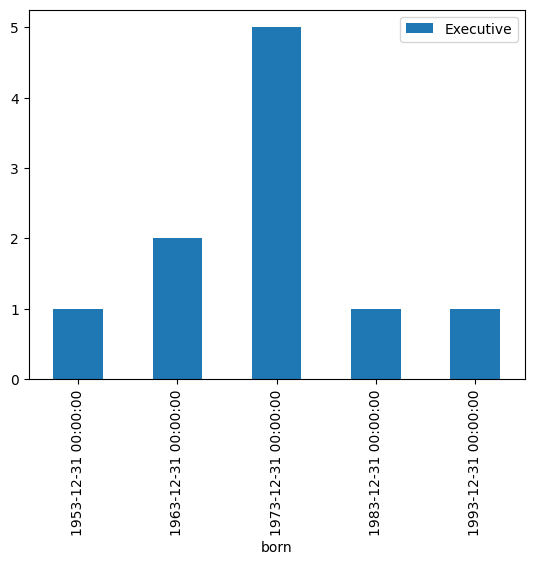

In [59]:
birthdays.resample('10A').count().plot(kind='bar')

Maybe that's a little weird.  Can we do something more along the lines of what we expect, i.e., "1920s, 1930s, ..."?

<ipython-input-60-9b886feb078d>:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  bdays = bdays.applymap(lambda bday: str(int(bday.year / 10) * 10) + 's')


<Axes: xlabel='born'>

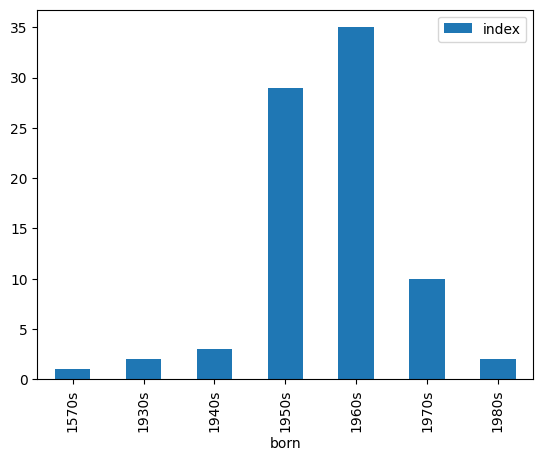

In [60]:
# Get rid of the nulls!
bdays = total[['born']].dropna()

bdays = bdays.applymap(lambda bday: str(int(bday.year / 10) * 10) + 's')

bdays.reset_index().groupby('born').count().plot(kind='bar')

# An Exercise

Is there a correlation between the kind of company and the age of the CEO?

Does the company's line of business matter?